In [1]:
# coding: utf-8
# inception_v4_pred.ipynb
# Inception-v4, Inception-ResNet and the Impact of Residual Connections on Learning
# http://arxiv.org/pdf/1602.07261v1.pd 

In [2]:
import numpy as np
import tensorflow as tf
import warnings
import matplotlib.pyplot as plt

# from keras.layers.convolutional import MaxPooling2D, Conv2D, AveragePooling2D
from keras.layers import Input, Dropout, Dense, Flatten, Activation, MaxPooling2D, Conv2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import concatenate

from keras.initializers import he_normal
from keras.regularizers import l2
from keras.models import Model

from keras import backend as K
# -from keras.applications.imagenet_utils import decode_predictions
from keras.utils.layer_utils import convert_all_kernels_in_model
from keras.utils.data_utils import get_file
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from skimage.io import imread

In [3]:
# Set up the GPU to avoid the runtime error: Could not create cuDNN handle...
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
# Assume users have already download the Inception v4 weights 
WEIGHTS_PATH = '/home/mike/keras_dnn_models/inception-v4_weights_tf_dim_ordering_tf_kernels.h5'
WEIGHTS_PATH_NO_TOP = '/home/mike/keras_dnn_models/inception-v4_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [5]:
def conv_bn(x, filters, kernel_size, strides, padding='same', use_bias=False):
    # Define the joint function to apply the combination of Conv and BatchNorm 
    x = Conv2D(filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias,
               kernel_initializer="he_normal", kernel_regularizer=l2(0.00004))(x)
    x = BatchNormalization(axis=3, momentum=0.9997, scale=False)(x)
    x = Activation('relu')(x)

    return x

In [6]:
def inception_stem(input):

    stem = conv_bn(input, filters=32, kernel_size=(3,3), strides=(2,2), padding='valid')
    stem = conv_bn(stem, filters=32, kernel_size=(3,3), strides=(1,1), padding='valid')
    stem = conv_bn(stem, filters=64, kernel_size=(3,3), strides=(1,1))

    branch_11 = MaxPooling2D((3,3), strides=(2,2), padding='valid')(stem)
    branch_12 = conv_bn(stem, filters=96, kernel_size=(3,3), strides=(2,2), padding='valid')
    stem = concatenate([branch_11, branch_12], axis=3)

    branch_13 = conv_bn(stem, filters=64, kernel_size=(1,1), strides=(1,1))
    branch_14 = conv_bn(branch_13, filters=96, kernel_size=(3,3), strides=(1,1), padding='valid')
    branch_15 = conv_bn(stem, filters=64, kernel_size=(1,1), strides=(1,1))
    branch_16 = conv_bn(branch_15, filters=64, kernel_size=(1,7), strides=(1,1))
    branch_17 = conv_bn(branch_16, filters=64, kernel_size=(7,1), strides=(1,1))
    branch_18 = conv_bn(branch_17, filters=96, kernel_size=(3,3),  strides=(1,1), padding='valid')
    stem = concatenate([branch_14,branch_18], axis=3)

    branch_19 = conv_bn(stem, filters=192, kernel_size=(3,3), strides=(2,2), padding='valid')
    branch_20 = MaxPooling2D((3,3), strides=(2,2), padding='valid')(stem)
    x = concatenate([branch_19,branch_20], axis=3)
  
    return x

In [7]:
def inception_a(input):

    branch_11 = conv_bn(input, filters=96, kernel_size=(1,1), strides=(1,1))

    branch_12 = conv_bn(input, filters=64, kernel_size=(1,1), strides=(1,1) )
    branch_22 = conv_bn(branch_12, filters=96, kernel_size=(3,3), strides=(1,1))

    branch_13 = conv_bn(input, filters=64, kernel_size=(1,1), strides=(1,1))
    branch_23 = conv_bn(branch_13, filters=96, kernel_size=(3,3), strides=(1,1))
    branch_33 = conv_bn(branch_23, filters=96, kernel_size=(3,3), strides=(1,1))

    branch_14 = AveragePooling2D((3,3), strides=(1,1), padding='same')(input)
    branch_24 = conv_bn(branch_14, filters=96, kernel_size=(1,1), strides=(1,1))

    x = concatenate([branch_11,branch_22,branch_33,branch_24], axis=3)
    
    return x


def reduction_a(input):

    branch_11 = conv_bn(input, filters=384, kernel_size=(3,3), strides=(2,2), padding='valid')

    branch_12 = conv_bn(input, filters=192, kernel_size=(1,1), strides=(1,1))
    branch_22 = conv_bn(branch_12, filters=224, kernel_size=(3,3), strides=(1,1))
    branch_32 = conv_bn(branch_22, filters=256, kernel_size=(3,3), strides=(2,2), padding='valid')

    branch_13 = MaxPooling2D((3,3), strides=(2,2), padding='valid')(input)

    x = concatenate([branch_11,branch_32,branch_13], axis=3)

    return x


def inception_b(input):

    branch_11 = conv_bn(input, filters=384, kernel_size=(1,1), strides=(1,1))

    branch_12 = conv_bn(input, filters=192, kernel_size=(1,1), strides=(1,1))
    branch_22 = conv_bn(branch_12, filters=224, kernel_size=(1,7), strides=(1,1))
    branch_32 = conv_bn(branch_22, filters=256, kernel_size=(7,1), strides=(1,1))

    branch_13 = conv_bn(input, filters=192, kernel_size=(1,1), strides=(1,1))
    branch_23 = conv_bn(branch_13, filters=192, kernel_size=(7,1), strides=(1,1))
    branch_33 = conv_bn(branch_23, filters=224, kernel_size=(1,7), strides=(1,1))
    branch_43 = conv_bn(branch_33, filters=224, kernel_size=(7,1), strides=(1,1))
    branch_53 = conv_bn(branch_43, filters=256, kernel_size=(1,7), strides=(1,1))

    branch_14 = AveragePooling2D((3,3), strides=(1,1), padding='same')(input)
    branch_24 = conv_bn(branch_14, filters=128, kernel_size=(1,1), strides=(1,1))

    x = concatenate([branch_11,branch_32,branch_53,branch_24], axis=3)

    return x


def reduction_b(input):

    branch_11 = conv_bn(input, filters=192, kernel_size=(1,1), strides=(1,1))
    branch_21 = conv_bn(branch_11, filters=192, kernel_size=(3,3), strides=(2,2), padding='valid')

    branch_12 = conv_bn(input, filters=256, kernel_size=(1,1), strides=(1,1))
    branch_22 = conv_bn(branch_12, filters=256, kernel_size=(1,7), strides=(1,1))
    branch_32 = conv_bn(branch_22, filters=320, kernel_size=(7,1), strides=(1,1))
    branch_42 = conv_bn(branch_32, filters=320, kernel_size=(3,3), strides=(2,2), padding='valid')

    branch_13 = MaxPooling2D((3,3), strides=(2,2), padding='valid')(input)

    x = concatenate([branch_21,branch_42,branch_13], axis=3)

    return x


def inception_c(input):

    branch_11 = conv_bn(input, filters=256, kernel_size=(1,1), strides=(1,1))

    branch_12 = conv_bn(input, filters=384, kernel_size=(1,1), strides=(1,1))
    branch_22 = conv_bn(branch_12, filters=256, kernel_size=(1,3), strides=(1,1))
    branch_23 = conv_bn(branch_12, filters=256, kernel_size=(3,1), strides=(1,1))
    branch_33 = concatenate([branch_22,branch_23], axis=3)

    branch_14 = conv_bn(input, filters=384, kernel_size=(1,1), strides=(1,1))
    branch_24 = conv_bn(branch_14, filters=448, kernel_size=(3,1), strides=(1,1))
    branch_34 = conv_bn(branch_24, filters=512, kernel_size=(1,3), strides=(1,1))
    branch_44 = conv_bn(branch_34, filters=256, kernel_size=(1,3), strides=(1,1))
    branch_45 = conv_bn(branch_34, filters=256, kernel_size=(3,1), strides=(1,1))
    branch_55 = concatenate([branch_44,branch_45], axis=3)

    branch_16 = AveragePooling2D((3,3), strides=(1,1), padding='same')(input)
    branch_26 = conv_bn(branch_16, filters=256, kernel_size=(1,1), strides=(1,1))

    x = concatenate([branch_11,branch_33,branch_55,branch_26], axis=3)

    return x

In [8]:
def inception_v4(input_shape, num_classes, weights, include_top):
    # Build the abstract Inception v4 network
    '''
    Args:
        input_shape: three dimensions in the TensorFlow Data Format
        num_classes: number of classes
        weights: pre-defined Inception v4 weights 
        include_top: a boolean, for full traning or finetune 
    Return: 
        logits: the logit outputs of the model.
    '''
    # Input() initizate a 3-D shape(weight,height,channels) into a 4-D tensor(batch, weight, 
    # height, channels). If no batch size, it is defaulted as None.
    inputs = Input(shape=input_shape)

    # Call the function of inception_stem()
    x = inception_stem(inputs)

    # 4 x Inception-A blocks: 35 x 35 x 384
    for i in range(0, 4):
        x = inception_a(x)

    # Reduction-A block: # 35 x 35 x 384
    x = reduction_a(x)

    # 7 x Inception-B blocks: 17 x 17 x 1024
    for i in range(0, 7):
        x = inception_b(x)

    # Reduction-B block: 17 x 17 x 1024
    x = reduction_b(x)

    # 3 x Inception-C blocks: 8 x 8 x 1536
    for i in range(0, 3):
        x = inception_c(x)

    # Final pooling and prediction
    if include_top:
        # 1 x 1 x 1536
        x = AveragePooling2D((8,8), padding='valid')(x)
        x = Dropout(0.5)(x)
        x = Flatten()(x)
        x = Dense(units=num_classes, activation='softmax')(x)

    model = Model(inputs, x, name='inception_v4')

    # load weights
    if weights == 'imagenet':
        if include_top:
            weights_path = WEIGHTS_PATH
        else:
            weights_path = WEIGHTS_PATH_NO_TOP
        # -model.load_weights(weights_path, by_name=True)
        model.load_weights(weights_path)

    return model

In [9]:
def preprocess_input(x):

    x = image.img_to_array(x)
    x = np.expand_dims(x, axis=0)
    x = np.divide(x, 255.0)
    x = np.subtract(x, 0.5)
    output = np.multiply(x, 2.0)

    return output

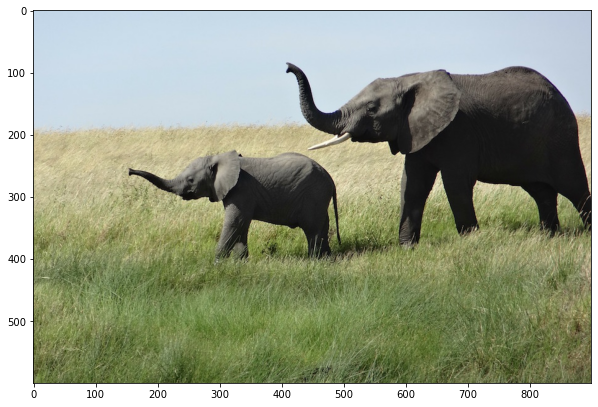

In [10]:
# Test the image
img_path = '/home/mike/Documents/keras_inception_v4/images/elephant.jpg'
image = imread(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.show()

In [11]:
input_shape = (299,299,3)
num_classes = 1001
weights='imagenet'
include_top = True 

model = inception_v4(input_shape, num_classes, weights, include_top)
model.summary()

Model: "inception_v4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [12]:
from keras.preprocessing import image
from keras.preprocessing.image import load_img

if __name__ == '__main__':

    model = inception_v4(input_shape, num_classes, weights, include_top)

    # Give a specific image for processing 
    img = image.load_img(img_path, target_size=(299,299))
    output = preprocess_input(img)

    # Open the class label dictionary, i.e., a human readable label-given ID. 
    classes = eval(open('/home/mike/Documents/keras_inception_v4/validation_utils/class_names.txt', 'r').read())

    # Run the prediction on the given image
    preds = model.predict(output)

    # Pring the predicted result 
    print("Class is: " + classes[np.argmax(preds)-1])
    print("Certainty is: " + str(preds[0][np.argmax(preds)]))

Class is: African elephant, Loxodonta africana
Certainty is: 0.8177135
